Author: TeamJuice: Zolbayar, Altangerel, Sharavsambuu

About: Bus arrival prediction model training

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.2.0-rc1'

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [0]:
!ls /content/drive/My\ Drive/ML\ Datasets/kaggle/datanomads_busarrival/

bus_id_encoder.pickle	   cleaned_train.csv	    training.csv
busstop_id_encoder.pickle  route_id_encoder.pickle
checkpoints		   test.csv


In [0]:
# Data cleansing буюу шаардлагатай feature-уудыг бэлтгэх notebook-ээс гаргасан csv файлыг машин сургалтанд хэрэглэнэ
train_df = pd.read_csv("/content/drive/My Drive/ML Datasets/kaggle/datanomads_busarrival/cleaned_train.csv")

In [0]:
"""
Машин сургалтан хэрэглэх feature-үүд үүнд: 
- DAY_OF_WEEK : Долоо хоногийн хэд дэх өдөр вэ? [0-6]
- TIME        : Өглөөний зургаан цагаас хойш хэдэн секунт өнгөрсөн байна
- BUS_ID      : Ямар дугаартай автобус вэ
- BUSROUTE_ID : Аль чиглэлд явж байгаа вэ
- BUSSTOP_ID  : Энэ автобус аль зогсоол дээр байна
"""
train_input = train_df[['DAY_OF_WEEK', 'TIME', 'BUS_ID', 'BUSROUTE_ID', 'BUSSTOP_ID']]

"""
Prediction хийхдээ тухайн зогсоол дээр ирсэн автобус дараагийн зогсоол хүртлээ 
хэдэн секунт явах вэ гэдгийг илтгэсэн багана ашиглана
"""
train_label = train_df[['TIMESTAMP_DIFF']]

In [0]:
# Tensorflow-т машин сургалтын өгөгдлийг batch-аар авахад хэрэглэхээр хувиргах
training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(train_input.values, tf.int32),
            tf.cast(train_label.values, tf.float32)
        )
    )
)

In [0]:
"""
Positional encoding буюу ямар нэгэн байрлалын дугаарыг давтагдашгүй вектороор 
илэрхийлэх, үүнийг өглөөний 6-н цагаас хойш хэдэн секунт өнгөрсөн байна гэдэг
дээр хэрэглэнэ. 
Transformer моделийн кодноос шууд авч хэрэглэсэн.
https://www.tensorflow.org/tutorials/text/transformer#positional_encoding
""""
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                        np.arange(d_model)[np.newaxis, :],
                        d_model)
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
  pos_encoding = angle_rads[np.newaxis, ...]
  return tf.cast(pos_encoding, dtype=tf.float32)

In [0]:
"""
Өглөөний 6-н цагаас оройн 24 цаг хүртлэх 18-н цагуудын секунт тус бүрийг нийт
18*3600=64800-н байрлал гэж үзээд байрлал тус 64-н dimension-тэй векторлуу буулгах туршилт
"""
time_dim      = 64
total_seconds = 18*3600 # 18hours
pos_encoding  = positional_encoding(total_seconds, time_dim)
print(pos_encoding.shape)

(1, 64800, 64)


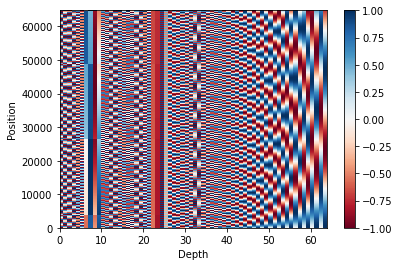

In [0]:
# Үүсгэсэн байрлалын векторуудыг зурж харах
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, time_dim))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [0]:
# Дараагийн автобусны буудал хүртэл хэдэн секунт явах вэ гэдгийг таамаглах модель
class BusNet(tf.keras.Model):
  def __init__(self, **kwargs):
    super(BusNet, self).__init__(**kwargs)
    
    self.week          = [0, 1, 2, 3, 4, 5, 6] # Долоо хоногийн өдрүүдийн давтагдашгүй дугаар
    self.time_dim      = 64                    # 6-н цагаас хойшхи секунтын байрлалыг илэрхийлэх векторын dimension
    self.time_count    = 18*3600               # 6-н цагаас хойш оройн 24-н цаг хүртэл илэрхийлэгдэх нийт секунтуудын тоо

    self.bus_dim       = 32                    # Автобусыг илэрхийлэх векторын dimension
    self.bus_count     = 1077                  # Нийт сургалтанд хэрэглэгдэх давтагдашгүй автобуснуудын тоо

    self.route_dim     = 16                    # Автобусны чиглэлийг илэрхийлэх векторын dimension
    self.route_count   = 353                   # Автобусны чиглэлийн тоо

    self.busstop_dim   = 32                    # Автобусны зогсоолыг илэрхийлэх векторын dimension
    self.busstop_count = 1357                  # Автобусны зогсоолын тоо
    
    self.dropout_rate  = 0.2                   # Моделио generalize хийхэд хэрэглэх dropout rate, тухайн layer-т байгаа
                                               # неорон холбоосуудын 0.2-г нь тэглэх буюу холбоосыг тайрч хаяна.

    # Долоо хоногийн өдрийн дугаарыг one encoding илэрхийллээр векторлуу буулгах
    self.day_of_week_embedding = tf.one_hot(self.week, len(self.week))
    # Positional encoding аргаар өглөөний 6-н цагаас хойшхи нийт байгаа секунтуудыг векторлуу буулгах хүснэг үүсгэх
    self.time_embedding        = positional_encoding(self.time_count, self.time_dim)
    
    # Embedding layer нь эхний утгуудаар цэнэглэгдэх боловч машин сургалтын явцад gradient update хийгдэж
    # хамгийн оптимал векторуудруу буулгагдан шинэчлэгдэнэ

    # Автобусыг илэрхийлэх векторуудын хүснэгтийг uniform утгуудаар дүүргэж цэнэглэх
    self.bus_embedding         = tf.keras.layers.Embedding(self.bus_count    , self.bus_dim    , embeddings_initializer='uniform', name='bus_embedding'    )
    # Автобусны чиглэлийг илэрхийлэх векторуудын хүснэгтийг эхний утгуудаар дүүргэж цэнэглэх
    self.route_embedding       = tf.keras.layers.Embedding(self.route_count  , self.route_dim  , embeddings_initializer='uniform', name='route_embedding'  )
    # Автобусны зогсоолыг илэрхийлэх векторуудын хүснэгтийг мөн дүүргэж цэнэглэх
    self.busstop_embedding     = tf.keras.layers.Embedding(self.busstop_count, self.busstop_dim, embeddings_initializer='uniform', name='busstop_embedding')

    # өмнөх layer-ээс буцаасан векторыг dimension нь 100 бүхий векторлуу буулгах давхарга
    self.layer_1      = tf.keras.layers.Dense(100, activation='relu')
    # эхний layer дээр хэрэглэх dropout
    self.dropout_1    = tf.keras.layers.Dropout(self.dropout_rate)
    # 64-н dimension лүү буулгах давхарга
    self.layer_2      = tf.keras.layers.Dense(64 , activation='relu')
    # 2-р давхарга дээр хэрэглэх dropout
    self.dropout_2    = tf.keras.layers.Dropout(self.dropout_rate)
    # 32 dimension лүү буулгах давхарга
    self.layer_3      = tf.keras.layers.Dense(32 , activation='relu')
    # 3-р layer дээр хэрэглэх dropout
    self.dropout_3    = tf.keras.layers.Dropout(self.dropout_rate)
    # Сүүлийн үр дүн болох dimension нь 1 буюу ганц scalar утга predict хийх layer  
    self.output_layer = tf.keras.layers.Dense(1)

  def call(self, inputs, training=True):
    days_of_week   = inputs[:, 0] # batch өгөгдлөөс 7 хоногийн өдрүүдийн цувааг авах
    time_positions = inputs[:, 1] # batch-аас 6-н цагаас хойшхи секунтын байрлалуудын цувааг авах
    bus_ids        = inputs[:, 2] # batch-аас автобуснуудын жагсаалтуудыг авах
    route_ids      = inputs[:, 3] # batch-аас чиглэлүүдийн дугааруудын цувааг авах
    busstop_ids    = inputs[:, 4] # batch-аас автобусны жагсаалтуудын цувааг авах

    # Долоо хоногийн өдрүүдийн дугаарт харгалзах one-hot вектор илэрхийллүүдийг авах
    day_vectors     = tf.convert_to_tensor([self.day_of_week_embedding[day] for day in days_of_week])
    # Өглөөний 6-н цагаас хойш өнгөрсөн секунтэд харгалзах байрлалын вектор илэрхийллүүдийн цувааг авах
    time_vectors    = tf.convert_to_tensor([self.time_embedding[:, time_pos, :][0] for time_pos in time_positions], dtype=tf.float32)
    # Энэ классын байгуулагч функц дээр цэнэглэгдсэн embedding давхаргаас автосны ID-д харгалзах векторуудыг авах
    bus_vectors     = self.bus_embedding(bus_ids)
    # Автобусны зогсоолд харгалзах векторуудын цувааг embedding хүснэгтээс авах
    route_vectors   = self.route_embedding(route_ids)
    # Автобусны зогсоолын ID-д харгалзах векторуудыг embedding хүснэгтээс авах
    busstop_vectors = self.busstop_embedding(busstop_ids)
    
    # Вектор илэрхийлэлд орсон feature-үүдээ жагсаан өрж нэг том вектор болгох
    # 1 гэсэн утга нь эдгээр нь batch хэлбэртэй байгаа учраас batch-ийн дагуу 
    # босоо тэнхлэгээр векторуудаа нэгтгэнэ гэдгийг илэрхийлнэ. Өөрөөр хэлбэл
    # үр дүн мөн адил нэгтгэж өрсөн векторуудын batch байна гэсэн үг.
    concatted_input = tf.concat([
      day_vectors  ,
      time_vectors , 
      bus_vectors  , 
      route_vectors, 
      busstop_vectors
      ], 1)
    
    # Энд dropout давхарга дээр training төлөвөөр toggle-дох нь inference хийх
    # үед неорон холбоосуудыг яг тэр сурсан байгаа чигээр нь ашиглах бололцоо олгоно
    # зөвхөн машин сургалтын үед training төлвийг True болгож ашиглах хэрэгтэй.

    # Нэгтгэлд орсон оролтын feature векторуудыг layer1 ээр оруулж dimension нь
    # 100 бүхий шинэ векторуудын цуваануудруу буулгах
    x = self.layer_1(concatted_input)
    # layer1 дэх неорон холбоосуудыг 0.2-г санамсаргүйгээр сонгоод хайчилж хаях
    # ингэснээр модель илүү ерөнхий байдлаар суралцаж overfit хийгдэхээс сэргийлнэ
    x = self.dropout_1(x, training=training)
    # layer1-ээс буцсан векторуудын цувааг layer2-оор оруулж 64-н dimension-тэй векторуудруу буулгах
    x = self.layer_2(x)
    # layer2 дээр dropout хэрэглэх
    x = self.dropout_2(x, training=training)
    # layer2-г 32 dimension-луу буулгах
    x = self.layer_3(x)
    # layer3 дээр dropout хэрэглэх
    x = self.dropout_3(x, training=training)
    # Эцсийн үр дүн буюу нэг автобусны зогсоолоос нөгөө автобусны зогсоол хүртэл
    # зорчих хугацааг batch байдлаар буцаах
    return self.output_layer(x)

In [0]:
# BusNet моделио үүсгэх
model = BusNet(dynamic=True)

In [0]:
# Неорон сүлжээ сургахад шаардлагатай туслах объектүүд.

# Outlier буюу машин сургалтын датаны тархалтаас гадуурхи өгөгдлүүд дээр илүү
# smooth ажилладаг гэдэг утгаар Huber loss тавьж хэрэглэв. MAE болон MSE хоёрын
# сайн талуудыг хоёуланг нь агуулдаг гэж сонссон.
loss_object    = tf.keras.losses.Huber()

# Adam optimizer, неорон сүлжээ дотор суралцах weight-үүдийг шинэчлэхэд хэрэглэх
# алгоритм. Өөр олон алгоритмууд бий боловч Adam нь илүү хурдан мөн accuracy өндөртэй.
optimizer      = tf.keras.optimizers.Adam()

# Тухайн batch өгөгдлүүд нь үндсэн true label-үүдтэй хэр зайтай байхыг хэмжихээр
# хоорондын ялгаваруудын абсолют утгуудын дунджуудыг тооцдог объект
train_loss     = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.MeanAbsoluteError(name='train_accuracy')

# Моделийн сурсан байгаа жингүүдийг тогтмол хадгалах үүрэгтэй объектүүд
# хамгийн сүүлийн 3-н checkpoint-үүдийг хадгалаад өмнөхүүдийг устгаж ажиллана
ckpt    = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(ckpt, '/content/drive/My Drive/ML Datasets/kaggle/datanomads_busarrival/checkpoints', max_to_keep=3)

In [0]:
# batch бүхий сургалтын өгөгдлүүдийг модельрүү чихэж градиентүүд гаргаж аваад
# неорон сүлжээний weight-үүдийг шинэчлэх үүрэгтэй функц. Товчоор машин сургах. 
def train_step(input_batch, label_batch):
  with tf.GradientTape() as tape:
    predictions = model(input_batch, training=True)
    loss        = loss_object(label_batch, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(label_batch, predictions)

In [0]:
# Хамгийн сүүлд хадгалсан checkpoint-ийг сэргээх
ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
  print("Restored from {}".format(manager.latest_checkpoint))
else:
  print("Initializing from scratch.")

Restored from /content/drive/My Drive/ML Datasets/kaggle/datanomads_busarrival/checkpoints/ckpt-505


In [0]:
# 5-н epoch буюу нийт сургалтын датасетээр 5-н удаа гүйж сургах. Нэг гүйхдээ 
# датасетээ 256-н ширхэг сургалтын өгөгдөл бүхий batch-уудаа хэсэглэн хувааж 
# сургана. 1 batch чихэх үйлдлийг нэг step гэж үзнэ.

epochs     = 5
batch_size = 256

for epoch in range(0, epochs):
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  print("starting of epoch", epoch)

  for step, (t_input, t_target) in enumerate(training_dataset.shuffle(buffer_size=int(len(train_df)-len(train_df)*8/10), reshuffle_each_iteration=True).batch(batch_size)):
    train_step(t_input, t_target)
    
    if step % 200 == 0:
      print("epoch:", epoch, "step:", step, "training loss", float(train_loss.result()), "training accuracy", float(train_accuracy.result()))

    ckpt.step.assign_add(1)
    if int(ckpt.step) % 1500 == 0:
      save_path = manager.save()
      print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))

starting of epoch 0
epoch: 0 step: 0 training loss 32.937862396240234 training accuracy 33.43063735961914
epoch: 0 step: 200 training loss 37.31827926635742 training accuracy 37.81245803833008
epoch: 0 step: 400 training loss 37.39413833618164 training accuracy 37.88839340209961
epoch: 0 step: 600 training loss 37.44839859008789 training accuracy 37.942623138427734
epoch: 0 step: 800 training loss 37.50531005859375 training accuracy 37.999488830566406
epoch: 0 step: 1000 training loss 37.64931869506836 training accuracy 38.1434440612793
epoch: 0 step: 1200 training loss 37.772674560546875 training accuracy 38.266754150390625
epoch: 0 step: 1400 training loss 37.81902313232422 training accuracy 38.313148498535156
Saved checkpoint for step 247500: /content/drive/My Drive/ML Datasets/kaggle/datanomads_busarrival/checkpoints/ckpt-506
epoch: 0 step: 1600 training loss 37.75710678100586 training accuracy 38.25126266479492
epoch: 0 step: 1800 training loss 37.75078582763672 training accuracy 

KeyboardInterrupt: ignored

In [0]:
# Сургах процесс дууссаны дараа нэг хэсэг дата сонгож аваад моделиороо predict хийж харах

window_index = 50000
y = model(train_input[window_index-3:window_index+3].values, training=False)
print("predicted:")
print(y.numpy())
print("true values:")
print(train_label[window_index-3:window_index+3].values)

m = tf.keras.metrics.MeanAbsoluteError()
_ = m.update_state(y, train_label[window_index-3:window_index+3].values) 
print("mean absolute error:", m.result().numpy())

predicted:
[[ 92.27257 ]
 [ 67.99572 ]
 [107.254974]
 [148.19733 ]
 [ 96.390724]
 [319.88983 ]]
true values:
[[ 83.]
 [ 59.]
 [ 79.]
 [152.]
 [ 93.]
 [342.]]
mean absolute error: 12.637805
